## Mathematical exercises: Pinhole camera
In these exercises we will assume a $modern$ camera with completely square pixels. What are the skew parameters then?

### Exercise 2.1
Reuse the box3d function from last week. Assume that $f$ = 600, $α$ = 1, $β$ = 0, and ${\delta}_x$ = ${\delta}_y$ = 400.
Given a traditional camera, what is the resolution in pixels?
>In a traditional camera, the principal point is exactly in the middle of the sensor. So, for this camera the sensor has 2 × 400 = 800 pixels along each dimension i.e. a resolution of 800 × 800 pixels.

Also assume $R$ = $I$, and $t = \begin{bmatrix}
0 \\ 0.2 \\ 1.5
\end{bmatrix}$
. Use projectpoints from last week, to project the
points.

Are all the points are captured by the image sensor?
Where does the corner $P_1$ = [−0.5,−0.5,−0.5] project to?

>The projection matrix reads $ p = \begin{bmatrix} 600 & 0 & 400 & 600 \\ 0 & 600 & 400 & 720  \\ 0 & 0 & 1 & 1.5 \end{bmatrix} $ Some points have an $y$ value greater than 800, and are not visible in the image, as they are outside the image sensor. $P_1$ projects to $[100,220]^T$

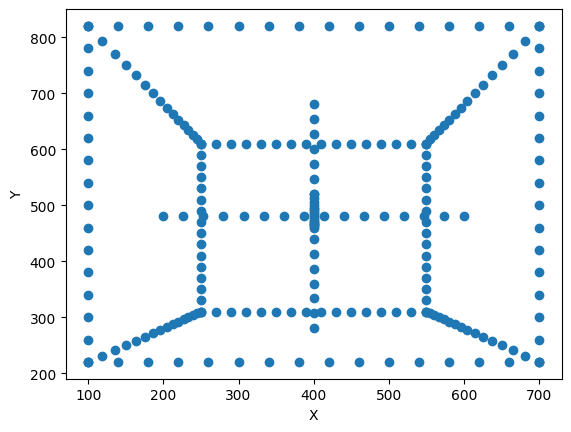

P1 projects to:  [[100.]
 [220.]]


In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def plot_box3d(n=16):
    points = box3d(n)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[0], points[1], points[2])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# converts from homogeneous to inhomogeneous coordinates
def Pi(ph):
    return ph[:-1]/ph[-1]
    
# converts from inhomogeneous to homogeneous coordinates
def PiInv(p):
    ones = np.ones((1, p.shape[1]))
    ph = np.vstack((p, ones))
    return ph

def projectpoints(K, R, t, Q):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    p = K @ PiInv(P)
    return p

def plot_figure(p):
    plt.scatter(p[0], p[1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


Q = box3d()
K = np.array([[600, 0, 400], [0, 600, 400], [0, 0, 1]])
R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
t = np.array([[0], [0.2], [1.5]])
P1 = np.array([[-0.5,-0.5,-0.5]]).T
p = projectpoints(K, R, t, Q)
p1 = projectpoints(K, R, t, P1)
plot_figure(p[:2])
print("P1 projects to: ", p1[:2])

### Exercise 2.2
Create a new or change your function projectpoints to a version that also takes distCoeffs as
an input. The list distCoeffs should contain the distortion coefficients $[k3, k5, k7, . . . ]$. Make the
function work for at least 3 coefficients.

Test your function with the same setup as in Exercise 2.1 and but assume that the distortion is
$$
\varDelta r(r)=-0.2r^2
$$
What are the distortion coefficients in this case?
> $k_3$ = -0.2, $k_5$ = 0, $k_7$ = 0, ...

Where does the corner $P_1$ project to?
> $[120.4, 232.24]^T$

Are all the points captured by the image sensor?
> All the points are now projecting inside the image, and will thus be visible.

Plot the results and try changing the distortion coefficients. Do they behave as they should?

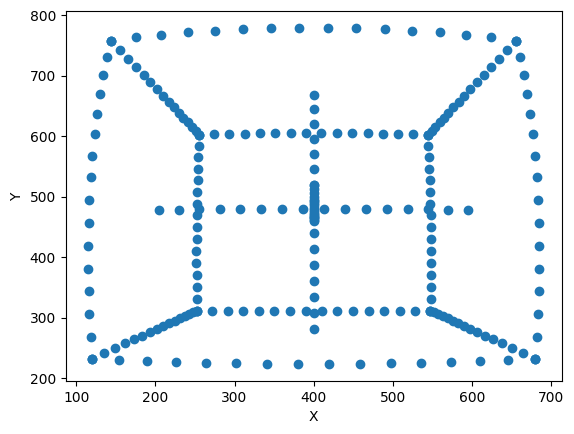

P1 projects to:  [[120.4 ]
 [232.24]]


In [2]:
def p_dist(P, distCoeffs):
    P_power = np.power(P,2)
    r = np.sqrt(P_power[0]+P_power[1]) # sqrt(x^2+y^2) 
    # Δr(r) = k3*r^2+k5*r^4+....
    delta_r = 0
    for i in range(len(distCoeffs)):
        delta_r += distCoeffs[i] * np.power(r, 2*i+2)
    
    P_dist = P * (delta_r +1)
    return P_dist

def projectpoints_dist(K, R, t, Q, distCoeffs):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    # then calculate dist(P)
    P_dist = p_dist(P,distCoeffs)
    q_d = PiInv(P_dist)
    p_d = K @ q_d

    return p_d

# Assume that the distortion is Δ(r)r=-0.2*r^2
# Barrel distortion
distCoeffs = [-0.2]
p = projectpoints_dist(K, R, t, Q, distCoeffs)
p1 = projectpoints_dist(K, R, t, P1, distCoeffs)

plot_figure(p[:2])
print("P1 projects to: ", p1[:2])

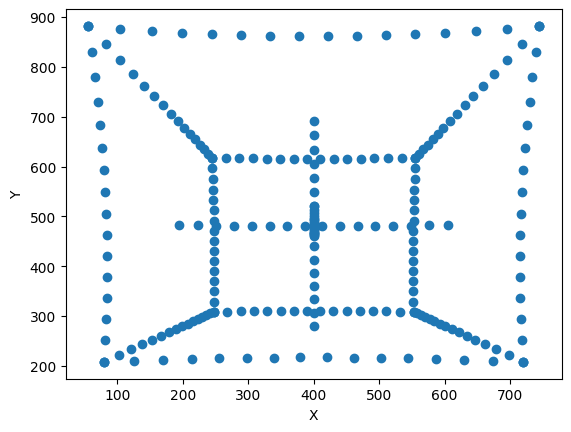

In [3]:
# Pincushion distortion
distCoeffs = [0.2]
p = projectpoints_dist(K, R, t, Q, distCoeffs)
plot_figure(p[:2])

### Exercise 2.3
Download the following image:
https://people.compute.dtu.dk/mohan/02504/gopro_robot.jpg

The image has been captured using a GoPro. Assume that the focal length is 0.455732 times the image width, and a reasonable guess of principal point, $\alpha$, and $\beta$. The distortion coefficients are
$$
k_3 = -0.245031, k_5 = 0.071524, k_7 = -0.00994978
$$
What is K?

In [4]:
import cv2

image = cv2.imread('gopro_robot.jpg')
(h, w, d) = image.shape

focal_length = 0.455732 * w
# The principal point is a reasonable guess, which we can assume as (960, 540) for this calculation.
K = np.array([[focal_length, 0, 960],
              [0, focal_length, 540],
              [0, 0, 1]])
print("The K is: ", K)


The K is:  [[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


### Exercise 2.4
Implement a function undistortImage that takes an image, a camera matrix, and distortion coefficients and returns an undistorted version of the same image. Use the following as an outline of your function

```
x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
q = ...
q_d = ...
p_d = ...
x_d = p_d[0].reshape(x.shape).astype(np.float32)
y_d = p_d[1].reshape(y.shape).astype(np.float32)
assert (p_d[2]==1).all(), 'You did a mistake somewhere'
im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
```
Test the function by undistorting the image from the previous exercise. Are the lines straight now?

$Tip$: Reshape $r$ back to an image and show it to check that it looks like expected.

In [7]:
def undistortImage(im, K, distCoeffs):
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    q = np.linalg.inv(K) @ p
    q_d = p_dist(Pi(q), distCoeffs)
    p_d = K @ PiInv(q_d)
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

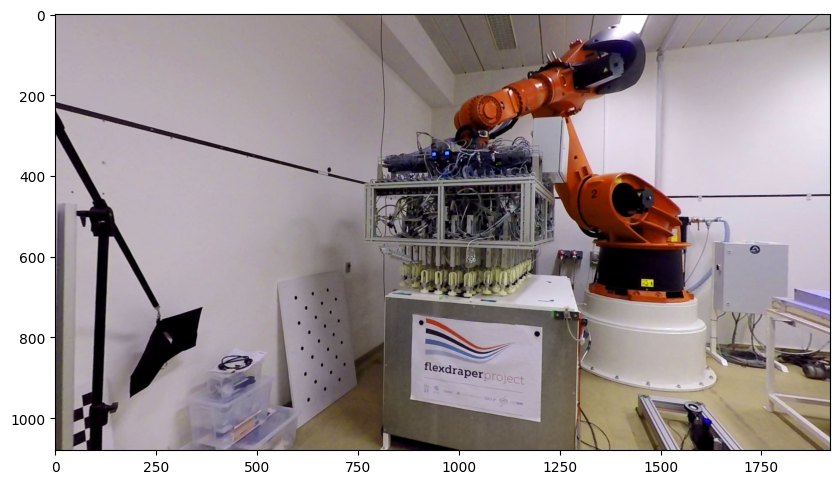

In [13]:
image = cv2.imread('gopro_robot.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
distCoeffs = [-0.245031, 0.071524, -0.00994978]
img = undistortImage(image, K, distCoeffs)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)